# Model Training and Baseline

The purpose of this notebook is to evaluate the NWPU Resic45 and Sentinel-2 cloudless datasets using a U-Net architecture for this semantic segmentation problem. Both datasets will be evaluated with and without data augmenation for comparisson.

The Resic45 dataset is composed of 662 images and the Sentinel-2 cloudless dataset is composed of 164 images.

The amount of augmented images for the baseline represents two times the number of each images on each dataset. Thus, the NWPU Resic45 model will be trained using 1986 images and the Sentinel-2 cloudless model will be trained using 492 images.

Moreover, the performance of the NWPU Resic45 model without image augmentation will be evaluated against the Sentinel-2 cloudless images to verify how well the model can generalize unseen data.

Finally, the training history will be plotted in order to measure the performance of each model in detail.

Remarks for the baseline:
- model based on the U-Net architecture;
- the input tensor of the network has shape (m, 512, 512, 3) where m is the number of training examples;
- the batch size is equal to 8;
- each dataset is splited as following: training (70%), validation (20%), and test (10%).

## External Dependencies

In [1]:
colab = True

Download external packages.

In [ ]:
if colab:
    !pip install rasterio
    #!pip install --default-timeout=1000 tensorflow-gpu==2.3

## Requirements

In [3]:
import os
import sys
module_path = os.path.abspath('deep-water')
if module_path not in sys.path:
    sys.path.append(module_path)

Import remaining dependencies.

In [4]:
import glob
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pprint
import rasterio
import random
import shutil
import tensorflow as tf
from metrics.jaccardIndex import mean_iou
from models.batchLoader import BatchLoader
from models.callbacks import baseline_callback
from models.dataAugmentationLoader import DataAugmentationLoader
from models.unet import Unet
from PIL import Image, ImageDraw
from tools.google_drive_downloader import GoogleDriveDownloader
%matplotlib inline

Verify if the notebook contains the expected Tensorflow version.

In [5]:
print("tensorflow version: ", tf.__version__)
assert tf.__version__ == '2.3.0'

tensorflow version:  2.3.0


Verify if there is a GPU allocated running in the background.

In [6]:
devices = tf.config.list_physical_devices('GPU')
assert type(devices[0]) == tf.python.eager.context.PhysicalDevice

The constants used in this notebook are defined as follows.

In [75]:
batch_size = 8
prop_training = 0.7
prop_validation = 0.2
epochs = 100
image_size = (256, 256)
baseline_file_id = '1WeGq3_n4MZ4Jyx-65GSa9GBt_aCxi6ao'
baseline_file_name = 'baseline_20200919.zip'
nwpu_image_folder = 'nwpu_images'
nwpu_augmented_image_folder = 'nwpu_augmented_images'
nwpu_mask_folder = 'nwpu_label_images'
nwpu_augmented_mask_folder = 'nwpu_label_augmented_images'
s2cloudless_image_folder = 's2cloudless_imagery'
s2cloudless_augmented_image_folder = 's2cloudless_augmented_imagery'
s2cloudless_mask_folder = 's2cloudless_label_imagery'
s2cloudless_augmented_mask_folder = 's2cloudless_label_augmented_imagery'
histories = {}
results = {}

Download training and test datasets.

In [76]:
google_drive_downloader = GoogleDriveDownloader()
google_drive_downloader.download(baseline_file_id, baseline_file_name, True)

uncompressing baseline_20200919.zip... Done.
downloading baseline_20200919.zip... Done.


Remove temporary folder and file.

In [77]:
shutil.rmtree('__MACOSX')
os.remove(baseline_file_name)

## Helper functions

Define a function to display the training history.

In [78]:
def plot_history(model_history):
    plt.figure(figsize=(10, 4))
    # Mean IoU
    plt.subplot(1, 2, 1)
    plt.plot(model_history.history["mean_iou"], label="train")
    plt.plot(model_history.history["val_mean_iou"], label="validation")
    plt.ylim(0, 1)
    plt.axhline(y=0.82, color='r')
    plt.title("Mean IoU vs Epoch Number")
    plt.ylabel('IoU')
    plt.xlabel('Epoch number')
    plt.legend(loc='lower right')
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(model_history.history["loss"], label="train")
    plt.plot(model_history.history["val_loss"], label="validation")
    plt.legend()
    plt.title("Loss vs Epoch Number")
    plt.ylabel('Loss')
    plt.xlabel('Epoch number')
    plt.legend(loc='upper right')
    plt.show()
    plt.close()

Define a function to display a list of training history.

In [79]:
def plot_histories(model_histories):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    for title, history in model_histories.items():
        plt.plot(history.history["val_loss"], label=title)
        plt.legend(loc='upper right')
        plt.title("Validation Loss")
    plt.subplot(1, 2, 2)
    for title, history in model_histories.items():
        plt.plot(history.history["val_mean_iou"], label=title)
        plt.legend(loc='lower right')
        plt.title("Validation IoU")
    plt.show()
    plt.close()

Define a function to create a pair of an image and a mask.

In [80]:
def pair_image_with_mask(image, mask):
    mask = mask.squeeze()
    mask = np.stack((mask,) * 3, axis=-1)
    return np.concatenate([image, mask], axis = 1)

Define a function to display six samples of the training data.

In [81]:
def display_training_samples(X, Y):
    samples_count = 6
    plt.figure(figsize=(24, 4))
    for i in range(samples_count):
        image = X[i]
        mask = Y[i].squeeze()
        subplot = plt.subplot(2, samples_count, 1 + i)
        subplot.get_xaxis().set_visible(False)
        subplot.get_yaxis().set_visible(False)
        plt.imshow(image)
        subplot = plt.subplot(2, samples_count, 7 + i)
        subplot.get_xaxis().set_visible(False)
        subplot.get_yaxis().set_visible(False)
        plt.imshow(mask, cmap="gray")
    plt.show()
    plt.close()

Define a function to display predictions pairs of a given image and its mask.

In [82]:
def display_predictions(X, Y, batch_size):
    columns_count = 2
    figure_size = (8, 10)
    rows = batch_size // columns_count
    _, axs = plt.subplots(rows, columns_count, figsize = figure_size)
    axs = axs.flatten()
    for i in range (0, batch_size):
        combined = pair_image_with_mask(X[i], Y[i])
        axs[i].axis('off')
        axs[i].imshow(combined)
    plt.tight_layout()

Define a function to move images from the augmented folder to the non-augmented folder

In [83]:
def move_augmented_files(augmented_folder, non_augmented_folder):
    augmented_images = glob.glob(os.path.join(augmented_folder, 'data', '*.jpg'))
    for original_file_path in augmented_images:
        augmented_file_name = original_file_path.split(os.sep)[-1]
        new_file_path = os.path.join(non_augmented_folder, 'data', augmented_file_name)
        shutil.move(original_file_path, new_file_path)

## Architecture

A summary of the model architecture that will be used for the four models presented in this notebook can be find detailed below.

In [84]:
_ = Unet('foo', image_size)
_.get_model_summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_135 (Conv2D)             (None, 256, 256, 8)  224         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_136 (Conv2D)             (None, 256, 256, 8)  584         conv2d_135[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_30 (MaxPooling2D) (None, 128, 128, 8)  0           conv2d_136[0][0]                 
______________________________________________________________________________________

## Training

### NWPU-Resic 45 dataset

Split dataset into training, validation and test datasets.

In [85]:
all_files = glob.glob(os.path.join(nwpu_image_folder, 'data', '*.jpg'))
all_files_count = len(all_files)
random.shuffle(all_files)
# training
training_split = int(prop_training * all_files_count)
train_files = all_files[0:training_split]
train_file_count = len(train_files)
train_steps = train_file_count // batch_size
# validation
validation_split = int(prop_validation * all_files_count)
validation_files = all_files[training_split:training_split+validation_split]
validation_file_count = len(validation_files)
validation_steps = validation_file_count // batch_size
# test
test_files = all_files[training_split+validation_split:]
test_file_count = len(test_files)

Display dataset split variables.

In [86]:
print("# images: {}".format(all_files_count))
print("# images for training: {}".format(train_file_count))
print("# images for validation: {}".format(validation_file_count))
print("# images for test: {}".format(test_file_count))
print("# training steps: {}".format(train_steps))
print("# validation steps: {}".format(validation_steps))
print("# batch size: {}".format(batch_size))

# images: 690
# images for training: 482
# images for validation: 138
# images for test: 70
# training steps: 60
# validation steps: 17
# batch size: 8


Create the generators for train and test datasets by instantiating the `BatchLoder` class to feed the model during training.

In [87]:
train_loader = BatchLoader(train_files, nwpu_image_folder, nwpu_mask_folder, batch_size, image_size)
train_generator = train_loader()
validation_loader = BatchLoader(validation_files, nwpu_image_folder, nwpu_mask_folder, batch_size, image_size)
validation_generator = validation_loader()
test_loader = BatchLoader(test_files, nwpu_image_folder, nwpu_mask_folder, test_file_count, image_size)
test_generator = test_loader()

#### Display a few samples from the training dataset

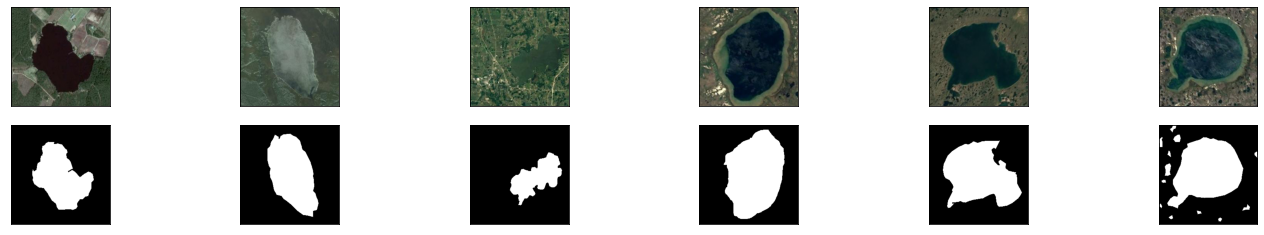

In [88]:
X_sample, Y_sample = next(train_generator)
display_training_samples(X_sample, Y_sample)

#### Create the model and attach optimizer, loss, and metrics

In [89]:
unet_nwpu = Unet('unet-nwpu', image_size)
model_name = unet_nwpu.model_name
unet_nwpu.set_compiler('binary_crossentropy', metrics=[mean_iou], optimizer='rmsprop')

#### Evaluating the model before training

In [90]:
X_test, Y_test = next(test_generator)
loss, iou = unet_nwpu.evaluate(X_test, Y_test)
print("Loss: {}".format(loss))
print("IoU: {}".format(iou))

Loss: 0.7102219462394714
IoU: 0.2328256368637085


#### Fit the model

In [91]:
callbacks = baseline_callback(model_name)
unet_nwpu.fit(train_generator, train_steps, validation_generator, validation_steps, epochs, callbacks)
histories[model_name] = unet_nwpu.history

Epoch 1/100
60/60 [==============================] - 7s 112ms/step - loss: 0.3788 - mean_iou: 0.3726 - val_loss: 0.2264 - val_mean_iou: 0.6130
Epoch 2/100
60/60 [==============================] - 6s 104ms/step - loss: 0.2946 - mean_iou: 0.6156 - val_loss: 0.2506 - val_mean_iou: 0.6212
Epoch 3/100
60/60 [==============================] - 6s 104ms/step - loss: 0.2570 - mean_iou: 0.6426 - val_loss: 0.4344 - val_mean_iou: 0.2518
Epoch 4/100
60/60 [==============================] - 6s 104ms/step - loss: 0.2424 - mean_iou: 0.6530 - val_loss: 0.2775 - val_mean_iou: 0.6360
Epoch 5/100
60/60 [==============================] - 6s 106ms/step - loss: 0.2176 - mean_iou: 0.6827 - val_loss: 0.1607 - val_mean_iou: 0.7742
Epoch 6/100
60/60 [==============================] - 6s 105ms/step - loss: 0.2387 - mean_iou: 0.6690 - val_loss: 0.1849 - val_mean_iou: 0.7191
Epoch 7/100
60/60 [==============================] - 6s 105ms/step - loss: 0.1900 - mean_iou: 0.7252 - val_loss: 0.1749 - val_mean_iou: 0.6920

#### Inspect the history

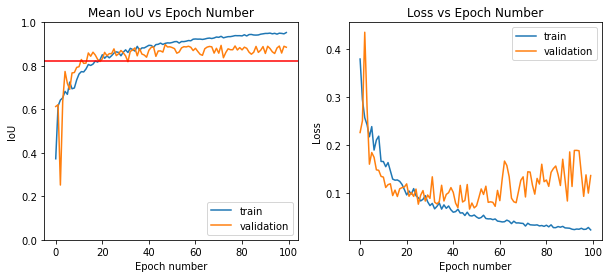

In [92]:
plot_history(unet_nwpu.history)

#### Evaluating the model after training

In [93]:
loss, iou = unet_nwpu.evaluate(X_test, Y_test)
results[model_name] = {"loss":loss, "iou":iou}
print("Loss: {}".format(loss))
print("IoU: {}".format(iou))

Loss: 0.28658631443977356
IoU: 0.8152914643287659


#### Display prediction results

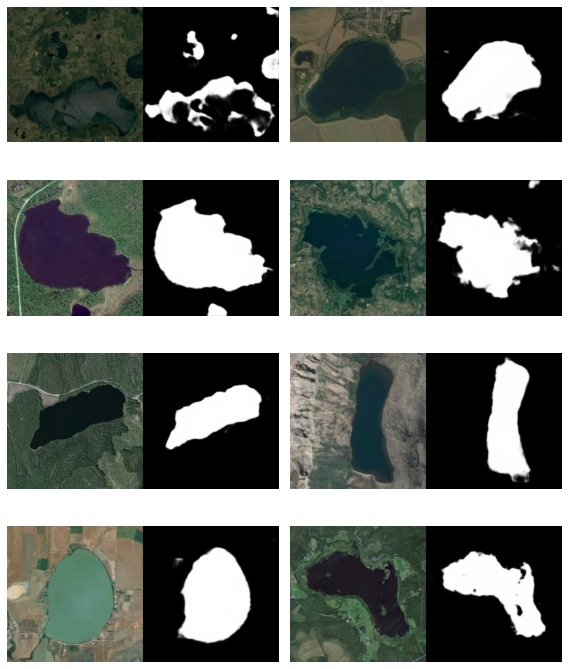

In [94]:
Y_pred = unet_nwpu.predict(X_test)
display_predictions(X_test, Y_pred, batch_size)

#### How good is the U-Net after training against unseen data from Sentinel-2?

Read all images from the Sentinel-2 dataset as the test set.

In [95]:
test_files = glob.glob(os.path.join(s2cloudless_image_folder, 'data', '*.jpg'))
test_file_count = len(test_files)
test_loader = BatchLoader(test_files, s2cloudless_image_folder, s2cloudless_mask_folder, test_file_count, image_size)
test_generator = test_loader()
X_test, Y_test = next(test_generator)

Compute the metrics.

In [96]:
loss, iou = unet_nwpu.evaluate(X_test, Y_test)
results[model_name] = {"loss":loss, "iou":iou}
print("Loss: {}".format(loss))
print("IoU: {}".format(iou))

Loss: 0.307658851146698
IoU: 0.7018888592720032


Display prediction results.

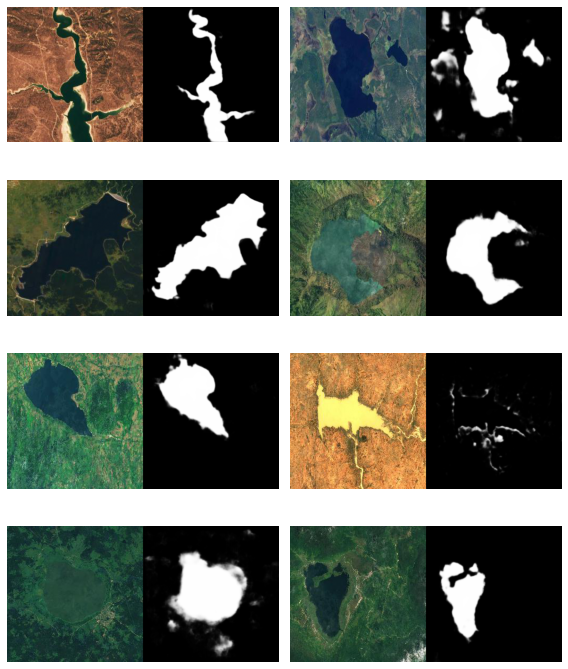

In [97]:
Y_pred = unet_nwpu.predict(X_test)
display_predictions(X_test, Y_pred, batch_size)

Delete the model.

In [98]:
del unet_nwpu

### Sentinel-2 cloudless dataset

Split dataset into training and test datasets.

In [99]:
all_files = glob.glob(os.path.join(s2cloudless_image_folder, 'data', '*.jpg'))
all_files_count = len(all_files)
random.shuffle(all_files)
# training
training_split = int(prop_training * all_files_count)
train_files = all_files[0:training_split]
train_file_count = len(train_files)
train_steps = train_file_count // batch_size
# validation
validation_split = int(prop_validation * all_files_count)
validation_files = all_files[training_split:training_split+validation_split]
validation_file_count = len(validation_files)
validation_steps = validation_file_count // batch_size
# test
test_files = all_files[training_split+validation_split:]
test_file_count = len(test_files)

Display dataset split variables.

In [100]:
print("# images: {}".format(all_files_count))
print("# images for training: {}".format(train_file_count))
print("# images for validation: {}".format(validation_file_count))
print("# images for test: {}".format(test_file_count))
print("# training steps: {}".format(train_steps))
print("# validation steps: {}".format(validation_steps))
print("# batch size: {}".format(batch_size))

# images: 359
# images for training: 251
# images for validation: 71
# images for test: 37
# training steps: 31
# validation steps: 8
# batch size: 8


Create the generators for train and test datasets by instantiating the `BatchLoder` class to feed the model during training.

In [101]:
train_loader = BatchLoader(train_files, s2cloudless_image_folder, s2cloudless_mask_folder, batch_size, image_size)
train_generator = train_loader()
validation_loader = BatchLoader(validation_files, s2cloudless_image_folder, s2cloudless_mask_folder, batch_size, image_size)
validation_generator = validation_loader()
test_loader = BatchLoader(test_files, s2cloudless_image_folder, s2cloudless_mask_folder, test_file_count, image_size)
test_generator = test_loader()

#### Display a few samples from the training dataset

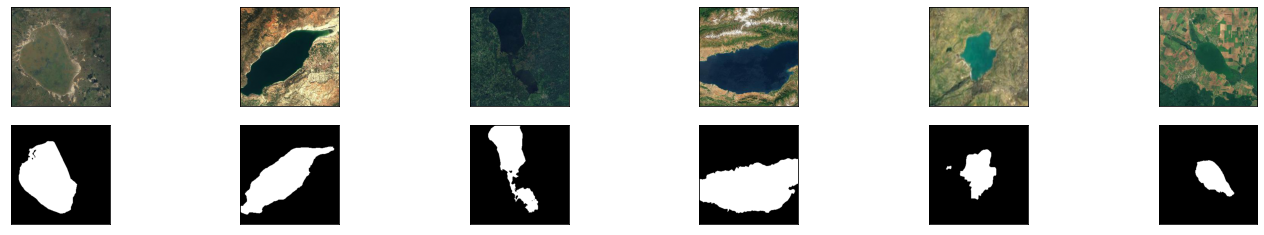

In [102]:
X_sample, Y_sample = next(train_generator)
display_training_samples(X_sample, Y_sample)

#### Create the model and attach optimizer, loss, and metrics

In [103]:
unet_s2cloudless = Unet('unet-s2cloudless', image_size)
model_name = unet_s2cloudless.model_name
unet_s2cloudless.set_compiler('binary_crossentropy', metrics=[mean_iou], optimizer='rmsprop')

#### Evaluating the model before training

In [104]:
X_test, Y_test = next(test_generator)
loss, iou = unet_s2cloudless.evaluate(X_test, Y_test)
print("Loss: {}".format(loss))
print("IoU: {}".format(iou))

Loss: 0.7617228031158447
IoU: 0.16434912383556366


#### Fit the model

In [105]:
callbacks = baseline_callback(model_name)
unet_s2cloudless.fit(train_generator, train_steps, validation_generator, validation_steps, epochs, callbacks)
histories[model_name] = unet_s2cloudless.history

Epoch 1/100
31/31 [==============================] - 4s 120ms/step - loss: 1.5538 - mean_iou: 0.0111 - val_loss: 0.4719 - val_mean_iou: 0.0000e+00
Epoch 2/100
31/31 [==============================] - 3s 108ms/step - loss: 0.4697 - mean_iou: 3.2341e-05 - val_loss: 0.4032 - val_mean_iou: 0.0000e+00
Epoch 3/100
31/31 [==============================] - 3s 108ms/step - loss: 0.4093 - mean_iou: 0.0157 - val_loss: 0.3267 - val_mean_iou: 9.6372e-04
Epoch 4/100
31/31 [==============================] - 3s 105ms/step - loss: 0.4542 - mean_iou: 0.0300 - val_loss: 0.3516 - val_mean_iou: 0.0000e+00
Epoch 5/100
31/31 [==============================] - 3s 105ms/step - loss: 0.3639 - mean_iou: 0.0251 - val_loss: 0.3718 - val_mean_iou: 2.9480e-05
Epoch 6/100
31/31 [==============================] - 3s 105ms/step - loss: 0.3376 - mean_iou: 0.0132 - val_loss: 0.3576 - val_mean_iou: 0.0037
Epoch 7/100
31/31 [==============================] - 3s 109ms/step - loss: 0.3499 - mean_iou: 0.2422 - val_loss: 0.323

#### Inspect the history

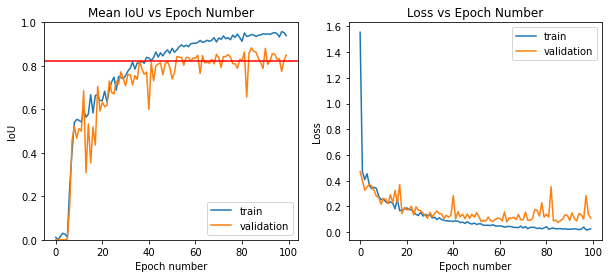

In [106]:
plot_history(unet_s2cloudless.history)

#### Evaluating the model after training

In [107]:
loss, iou = unet_s2cloudless.evaluate(X_test, Y_test)
results[model_name] = {"loss":loss, "iou":iou}
print("Loss: {}".format(loss))
print("IoU: {}".format(iou))

Loss: 0.19486667215824127
IoU: 0.857211709022522


#### Display prediction results

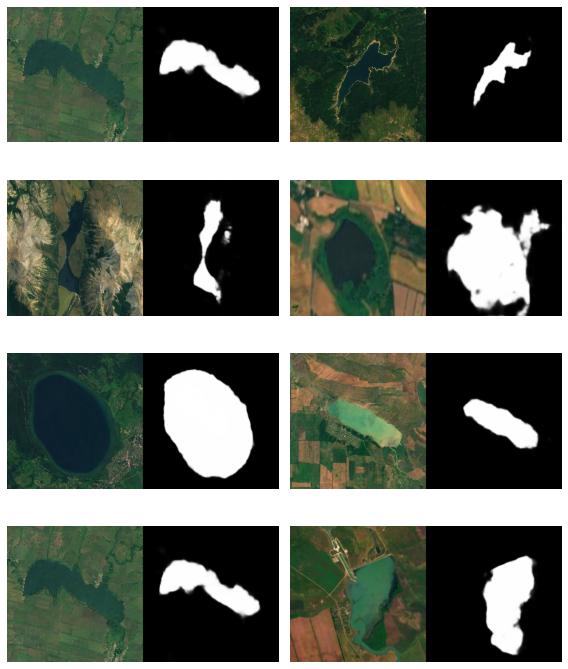

In [108]:
Y_pred = unet_s2cloudless.predict(X_test)
display_predictions(X_test, Y_pred, batch_size)

Delete the model.

In [109]:
del unet_s2cloudless

## Training with image augmentation

### NWPU-Resic 45 dataset

Copy augmented images and masks to the training dataset folder.

In [110]:
move_augmented_files(nwpu_augmented_image_folder, nwpu_image_folder)
move_augmented_files(nwpu_augmented_mask_folder, nwpu_mask_folder)

Split dataset into training and test datasets.

In [111]:
all_files = glob.glob(os.path.join(nwpu_image_folder, 'data', '*.jpg'))
all_files_count = len(all_files)
random.shuffle(all_files)
# training
training_split = int(prop_training * all_files_count)
train_files = all_files[0:training_split]
train_file_count = len(train_files)
train_steps = train_file_count // batch_size
# validation
validation_split = int(prop_validation * all_files_count)
validation_files = all_files[training_split:training_split+validation_split]
validation_file_count = len(validation_files)
validation_steps = validation_file_count // batch_size
# test
test_files = all_files[training_split+validation_split:]
test_file_count = len(test_files)

Display dataset split variables.

In [112]:
print("# images: {}".format(all_files_count))
print("# images for training: {}".format(train_file_count))
print("# images for validation: {}".format(validation_file_count))
print("# images for test: {}".format(test_file_count))
print("# training steps: {}".format(train_steps))
print("# validation steps: {}".format(validation_steps))
print("# batch size: {}".format(batch_size))

# images: 1380
# images for training: 965
# images for validation: 276
# images for test: 139
# training steps: 120
# validation steps: 34
# batch size: 8


Create the generators for train and test datasets by instantiating the `BatchLoder` class to feed the model during training.

In [113]:
train_loader = BatchLoader(train_files, nwpu_image_folder, nwpu_mask_folder, batch_size, image_size)
train_generator = train_loader()
validation_loader = BatchLoader(validation_files, nwpu_image_folder, nwpu_mask_folder, batch_size, image_size)
validation_generator = validation_loader()
test_loader = BatchLoader(test_files, nwpu_image_folder, nwpu_mask_folder, test_file_count, image_size)
test_generator = test_loader()

#### Display a few samples from the training dataset

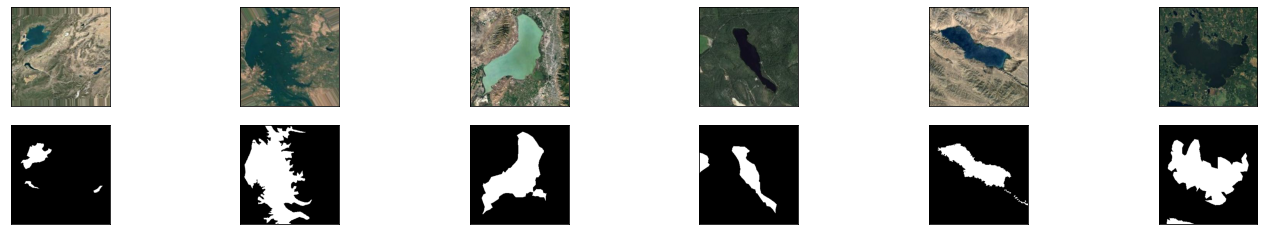

In [114]:
X_sample, Y_sample = next(train_generator)
display_training_samples(X_sample, Y_sample)

#### Create the model and attach optimizer, loss, and metrics

In [115]:
unet_nwpu_augmented = Unet('unet-nwpu-augmented', image_size)
model_name = unet_nwpu_augmented.model_name
unet_nwpu_augmented.set_compiler('binary_crossentropy', metrics=[mean_iou], optimizer='rmsprop')

#### Evaluating the model before training

In [116]:
X_test, Y_test = next(test_generator)
loss, iou = unet_nwpu_augmented.evaluate(X_test, Y_test)
print("Loss: {}".format(loss))
print("IoU: {}".format(iou))

Loss: 0.7116860747337341
IoU: 0.23840990662574768


#### Fit the model

In [117]:
callbacks = baseline_callback(model_name)
unet_nwpu_augmented.fit(train_generator, train_steps, validation_generator, validation_steps, epochs, callbacks)
histories[model_name] = unet_nwpu_augmented.history

Epoch 1/100
120/120 [==============================] - 13s 110ms/step - loss: 0.5841 - mean_iou: 0.1929 - val_loss: 0.3735 - val_mean_iou: 0.4132
Epoch 2/100
120/120 [==============================] - 13s 107ms/step - loss: 0.3615 - mean_iou: 0.6162 - val_loss: 0.2203 - val_mean_iou: 0.6397
Epoch 3/100
120/120 [==============================] - 13s 108ms/step - loss: 0.1994 - mean_iou: 0.6952 - val_loss: 0.1602 - val_mean_iou: 0.7804
Epoch 4/100
120/120 [==============================] - 13s 107ms/step - loss: 0.1729 - mean_iou: 0.7434 - val_loss: 0.1877 - val_mean_iou: 0.7038
Epoch 5/100
120/120 [==============================] - 13s 107ms/step - loss: 0.1587 - mean_iou: 0.7574 - val_loss: 0.1336 - val_mean_iou: 0.8104
Epoch 6/100
120/120 [==============================] - 13s 106ms/step - loss: 0.1576 - mean_iou: 0.7640 - val_loss: 0.1586 - val_mean_iou: 0.7780
Epoch 7/100
120/120 [==============================] - 13s 106ms/step - loss: 0.1437 - mean_iou: 0.7832 - val_loss: 0.1374 -

#### Inspect the history

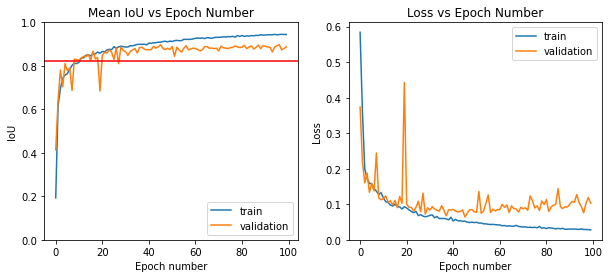

In [118]:
plot_history(unet_nwpu_augmented.history)

#### Evaluating the model after training

In [119]:
loss, iou = unet_nwpu_augmented.evaluate(X_test, Y_test)
results[model_name] = {"loss":loss, "iou":iou}
print("Loss: {}".format(loss))
print("IoU: {}".format(iou))

Loss: 0.16875042021274567
IoU: 0.8469408750534058


#### Display prediction results

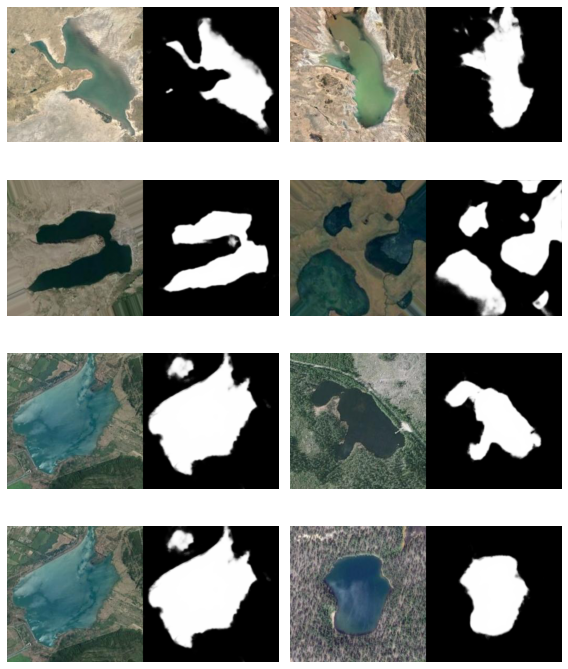

In [120]:
Y_pred = unet_nwpu_augmented.predict(X_test)
display_predictions(X_test, Y_pred, batch_size)

Delete the model.

In [121]:
del unet_nwpu_augmented

### Sentinel-2 cloudless dataset

Copy augmented images and masks to the training dataset folder.

In [122]:
move_augmented_files(s2cloudless_augmented_image_folder, s2cloudless_image_folder)
move_augmented_files(s2cloudless_augmented_mask_folder, s2cloudless_mask_folder)

Split dataset into training and test datasets.

In [123]:
all_files = glob.glob(os.path.join(s2cloudless_image_folder, 'data', '*.jpg'))
all_files_count = len(all_files)
random.shuffle(all_files)
# training
training_split = int(prop_training * all_files_count)
train_files = all_files[0:training_split]
train_file_count = len(train_files)
train_steps = train_file_count // batch_size
# validation
validation_split = int(prop_validation * all_files_count)
validation_files = all_files[training_split:training_split+validation_split]
validation_file_count = len(validation_files)
validation_steps = validation_file_count // batch_size
# test
test_files = all_files[training_split+validation_split:]
test_file_count = len(test_files)

Display dataset split variables.

In [124]:
print("# images: {}".format(all_files_count))
print("# images for training: {}".format(train_file_count))
print("# images for validation: {}".format(validation_file_count))
print("# images for test: {}".format(test_file_count))
print("# training steps: {}".format(train_steps))
print("# validation steps: {}".format(validation_steps))
print("# batch size: {}".format(batch_size))

# images: 718
# images for training: 502
# images for validation: 143
# images for test: 73
# training steps: 62
# validation steps: 17
# batch size: 8


Create the generators for train and test datasets by instantiating the `BatchLoder` class to feed the model during training.

In [125]:
train_loader = BatchLoader(train_files, s2cloudless_image_folder, s2cloudless_mask_folder, batch_size, image_size)
train_generator = train_loader()
validation_loader = BatchLoader(validation_files, s2cloudless_image_folder, s2cloudless_mask_folder, batch_size, image_size)
validation_generator = validation_loader()
test_loader = BatchLoader(test_files, s2cloudless_image_folder, s2cloudless_mask_folder, test_file_count, image_size)
test_generator = test_loader()

#### Display a few samples from the training dataset

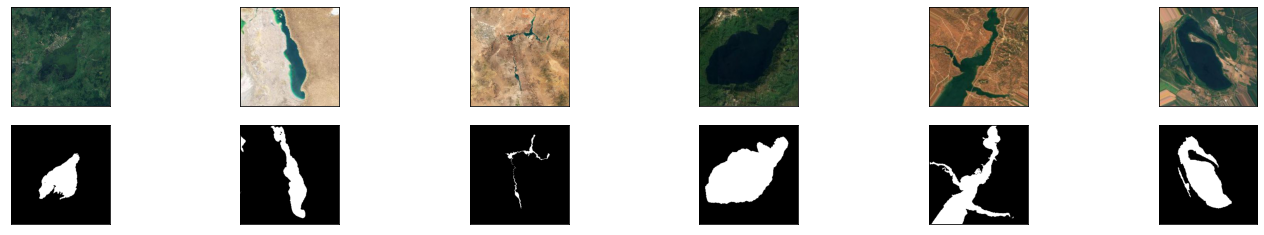

In [126]:
X_sample, Y_sample = next(train_generator)
display_training_samples(X_sample, Y_sample)

#### Create the model and attach optimizer, loss, and metrics

In [127]:
unet_s2cloudless_augmented = Unet('unet-s2cloudless-augmented', image_size)
model_name = unet_s2cloudless_augmented.model_name
unet_s2cloudless_augmented.set_compiler('binary_crossentropy', metrics=[mean_iou], optimizer='rmsprop')

#### Evaluating the model before training

In [128]:
X_test, Y_test = next(test_generator)
loss, iou = unet_s2cloudless_augmented.evaluate(X_test, Y_test)
print("Loss: {}".format(loss))
print("IoU: {}".format(iou))

Loss: 0.7327286005020142
IoU: 0.1641778200864792


#### Fit the model

In [129]:
callbacks = baseline_callback(model_name)
unet_s2cloudless_augmented.fit(train_generator, train_steps, validation_generator, validation_steps, epochs, callbacks)
histories[model_name] = unet_s2cloudless_augmented.history

Epoch 1/100
62/62 [==============================] - 7s 113ms/step - loss: 0.4550 - mean_iou: 0.0029 - val_loss: 0.3770 - val_mean_iou: 0.0000e+00
Epoch 2/100
62/62 [==============================] - 7s 107ms/step - loss: 0.3899 - mean_iou: 0.0320 - val_loss: 0.3459 - val_mean_iou: 0.1786
Epoch 3/100
62/62 [==============================] - 7s 108ms/step - loss: 0.3344 - mean_iou: 0.3363 - val_loss: 0.3018 - val_mean_iou: 0.3851
Epoch 4/100
62/62 [==============================] - 7s 106ms/step - loss: 0.3007 - mean_iou: 0.4707 - val_loss: 0.3858 - val_mean_iou: 0.2012
Epoch 5/100
62/62 [==============================] - 7s 108ms/step - loss: 0.2588 - mean_iou: 0.5408 - val_loss: 0.2535 - val_mean_iou: 0.4888
Epoch 6/100
62/62 [==============================] - 7s 108ms/step - loss: 0.2959 - mean_iou: 0.5195 - val_loss: 0.2380 - val_mean_iou: 0.5780
Epoch 7/100
62/62 [==============================] - 7s 108ms/step - loss: 0.2439 - mean_iou: 0.5738 - val_loss: 0.2185 - val_mean_iou: 0.

#### Inspect the history

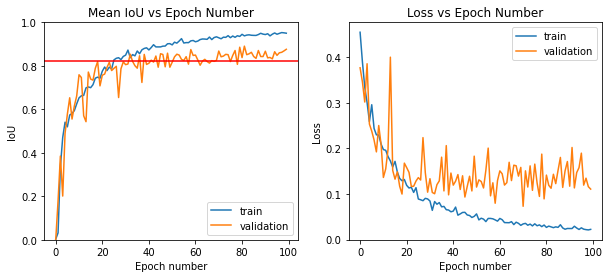

In [130]:
plot_history(unet_s2cloudless_augmented.history)

#### Evaluating the model after training

In [131]:
loss, iou = unet_s2cloudless_augmented.evaluate(X_test, Y_test)
results[model_name] = {"loss":loss, "iou":iou}
print("Loss: {}".format(loss))
print("IoU: {}".format(iou))

Loss: 0.23395507037639618
IoU: 0.8037407398223877


#### Display prediction results

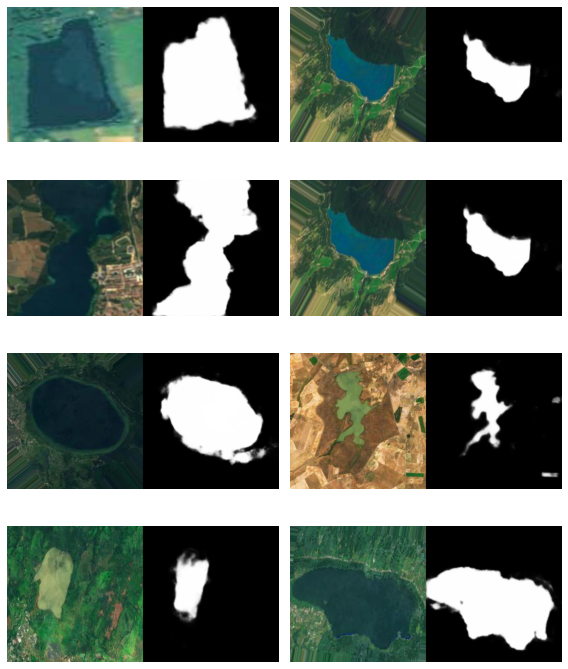

In [132]:
Y_pred = unet_s2cloudless_augmented.predict(X_test)
display_predictions(X_test, Y_pred, batch_size)

Delete the model.

In [133]:
del unet_s2cloudless_augmented

## Comparing the training history results

### Models without image augmentation

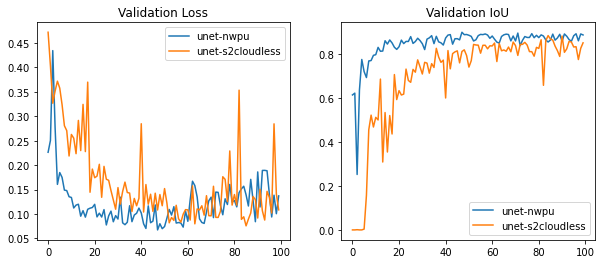

In [134]:
histories_without_image_augmentation = {title: history for title, history in histories.items() if not title.endswith("augmented")}
plot_histories(histories_without_image_augmentation)

### Models with image augmentation

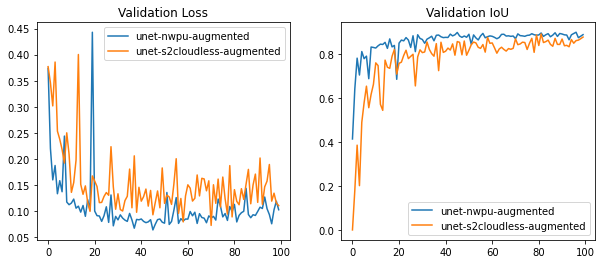

In [135]:
histories_with_image_augmentation = {title: history for title, history in histories.items() if title.endswith("augmented")}
plot_histories(histories_with_image_augmentation)

### NWPU Models

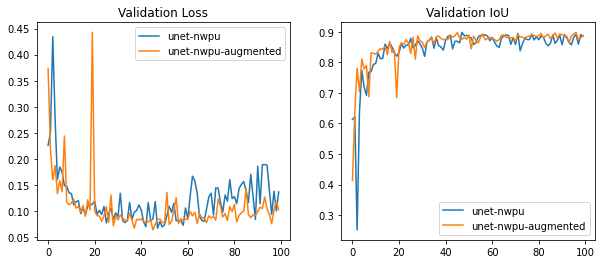

In [136]:
histories_nwpu = {title: history for title, history in histories.items() if "nwpu" in title}
plot_histories(histories_nwpu)

### Sentinel-2 Cloudless Models

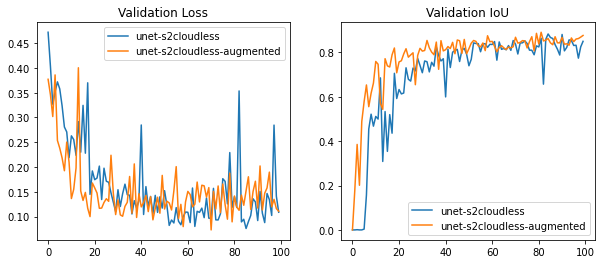

In [137]:
histories_s2cloudless = {title: history for title, history in histories.items() if "s2cloudless" in title}
plot_histories(histories_s2cloudless)

### All models

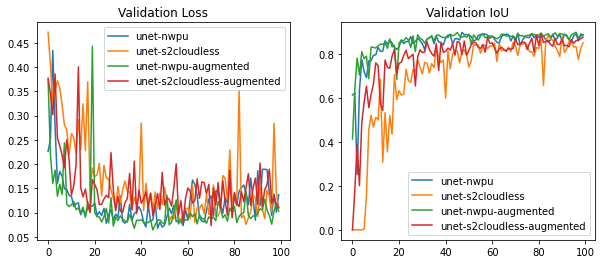

In [138]:
plot_histories(histories)

### Overall metrics

In [139]:
pprint.pprint(results, indent=2)

{ 'unet-nwpu': {'iou': 0.7018888592720032, 'loss': 0.307658851146698},
  'unet-nwpu-augmented': { 'iou': 0.8469408750534058,
                           'loss': 0.16875042021274567},
  'unet-s2cloudless': {'iou': 0.857211709022522, 'loss': 0.19486667215824127},
  'unet-s2cloudless-augmented': { 'iou': 0.8037407398223877,
                                  'loss': 0.23395507037639618}}


### House cleaning and delete temporary files.

Delete data files.

In [140]:
nwpu_image_folders = ['nwpu_images', 'nwpu_augmented_images', 'nwpu_label_images', 'nwpu_label_augmented_images']
sentinel2_image_folders = ['s2cloudless_imagery', 's2cloudless_augmented_imagery', 's2cloudless_label_imagery', 's2cloudless_label_augmented_imagery']
[shutil.rmtree(folder) for folder in nwpu_image_folders + sentinel2_image_folders]

[None, None, None, None, None, None, None, None]

Delete the models.

In [141]:
models = ['unet-s2cloudless.h5', 'unet-nwpu.h5', 'unet-s2cloudless-augmented.h5', 'unet-nwpu-augmented.h5']
[os.remove(model) for model in models]

[None, None, None, None]